In [1]:
# ───────────────────── 1. LIBRERÍAS ─────────────────────────────
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import cartopy.crs as ccrs
from utils import decimal_to_datetime, norm_dep
from matplotlib.lines import Line2D
import numpy as np
from matplotlib.patches import FancyArrowPatch
import random
import matplotlib.colors as colors
from adjustText import adjust_text
import math
from pathlib import Path
import matplotlib.font_manager as fm

In [2]:
# ───────────────────── 2. CONFIGURACIÓN DE FUENTES ─────────────────────────────

# Ruta al archivo .ttf de Arial
# Ruta relativa desde el notebook
font_path = Path("font/Arial.ttf")
arial_fp = fm.FontProperties(fname=str(font_path))
arial_name = arial_fp.get_name()

print("Nombre de la fuente registrada desde el archivo:", arial_name)

Nombre de la fuente registrada desde el archivo: Arial


In [3]:
# ───────────────────── 3. CARGA DE DATOS ───────────────────────
# Define la lista de archivos y los nombres de las variantes
file_paths = [
    Path("../data/Fig4_Lambda_CountryDateMovements.txt"),
    Path("../data/Fig4_P12_CountryDateMovements_v2.txt"),
    Path("../data/Fig4_XBB_CountryDateMovements_v2.txt"),
    Path("../data/Fig4_DJ1_CountryDateMovements_v2.txt")
]

variant_names = ['Lambda C.37', 'Gamma P.1.12', 'Omicron XBB.2.6', 'Omicron DJ.1']

# Lista para almacenar los DataFrames cargados
dfs_list = []

# Limpia nombres de países de los archivos antes de la normalización general
def clean_country_name(name):
    if pd.isna(name):
        return name
    name = str(name).strip()
    name = name.replace('_', ' ')

    # Aplica mapeos específicos para variaciones comunes en los archivos de datos
    mapping = {
        'USA': 'UNITED STATES OF AMERICA',
        'Costa Rica': 'COSTA RICA',
        'Czech Republic': 'CZECHIA',
        'Canary Islands': 'CANARY ISLANDS',
        'Netherlands': 'KINGDOM OF THE NETHERLANDS',
        'Saint Kitts and Nevis': 'SAINT KITTS AND NEVIS'
    }
    # Aplica el mapeo; si no se encuentra la clave, usa el nombre original ya limpiado
    name = mapping.get(name, name)

    # Aplica la normalización general (acentos, mayúsculas/minúsculas consistentes, etc.)
    normalized_name = norm_dep(name)

    return normalized_name


# Carga y procesa cada archivo
for file_path, variant_name in zip(file_paths, variant_names):
    try:
        df_variant = pd.read_csv(file_path, sep="\t")

        # Agrega la columna 'Variant' con el nombre correspondiente
        df_variant['Variant'] = variant_name

        # Convierte fechas decimales a datetime
        for col in ("ParentDate", "ChildDate"):
            df_variant[col] = df_variant[col].apply(decimal_to_datetime)

        # Normaliza y limpia nombres de países usando la función combinada
        for col in ("ParentCountry", "ChildCountry"):
            df_variant[col] = df_variant[col].apply(clean_country_name)

        # --- FILTRA PAÍSES "Other" ---
        initial_rows = len(df_variant)
        df_variant = df_variant[~df_variant['ParentCountry'].astype(str).str.startswith('Other')]
        df_variant = df_variant[~df_variant['ChildCountry'].astype(str).str.startswith('Other')]
        filtered_rows = len(df_variant)
        if initial_rows - filtered_rows > 0:
            print(f"Filtradas {initial_rows - filtered_rows} filas que comienzan con 'Other' en ParentCountry o ChildCountry para la variante {variant_name}.")


        # Agrega columnas de tiempo
        df_variant['año'] = df_variant['ParentDate'].dt.year
        df_variant['mes'] = df_variant['ParentDate'].dt.month
        df_variant['trimestre'] = df_variant['ParentDate'].dt.quarter

        dfs_list.append(df_variant)

    except FileNotFoundError:
        print(f"Error: El archivo {file_path} no fue encontrado.")
        continue
    except Exception as e:
        print(f"Ocurrió un error al procesar {file_path}: {e}")
        continue

# Concatena todos los DataFrames en uno solo
if dfs_list:
    df = pd.concat(dfs_list, ignore_index=True)
    df = df.sort_values('ParentDate') # Ordena el DataFrame combinado por fecha
    print(f"Total de movimientos cargados después de filtrar 'Other': {len(df)}")
else:
    print("No se cargaron archivos. Verifique las rutas y los nombres de archivo.")

# Define un diccionario de colores para las variantes
variant_colors = {
    'Lambda C.37': '#5A9BD4',
    'Gamma P.1.12': '#66B483',
    'Omicron XBB.2.6': '#E79643',
    'Omicron DJ.1': '#D45C5C'
}

# Agrupa movimientos por ruta única y variante
df_count = df.groupby(["ParentCountry", "ChildCountry", "Variant"]).size().reset_index(name="count")

# Define min_count y max_count desde el DataFrame combinado (ahora filtrado)
min_count = df_count['count'].min() if not df_count.empty else 0
max_count = df_count['count'].max() if not df_count.empty else 1
print(f"Min conteo: {min_count}, Max conteo: {max_count}")

# --- Depuración: Inspecciona nombres de países normalizados desde DataFrame ---
print("\nNombres de países normalizados de DataFrame:")
df_countries = pd.concat([df['ParentCountry'], df['ChildCountry']]).unique()
print(sorted(df_countries))
print(f"Total de países únicos en DataFrame: {len(df_countries)}")

Total de movimientos cargados después de filtrar 'Other': 3282
Min conteo: 1, Max conteo: 544

Nombres de países normalizados de DataFrame:
['ARGENTINA', 'AUSTRALIA', 'BELGIUM', 'BOLIVIA', 'BRAZIL', 'CANADA', 'CANARY ISLANDS', 'CHILE', 'COLOMBIA', 'COSTA RICA', 'CZECHIA', 'DENMARK', 'ECUADOR', 'EL SALVADOR', 'ENGLAND', 'FRANCE', 'GERMANY', 'INDIA', 'ISRAEL', 'ITALY', 'JAPAN', 'KINGDOM OF THE NETHERLANDS', 'MEXICO', 'OTHER AFRICA', 'OTHER ASIA', 'OTHER EUROPE', 'OTHER NORTH AMERICA', 'OTHER OCEANIA', 'OTHER SOUTH AMERICA', 'PANAMA', 'PERU', 'PUERTO RICO', 'SAINT KITTS AND NEVIS', 'SINT MAARTEN', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'UNITED STATES OF AMERICA']
Total de países únicos en DataFrame: 38


In [4]:
# ───────────────────── 4. SHAPEFILE Y COORDENADAS DE CAPITALES ───────────────
# Usa el shapefile de países para el fondo y el de ciudades pobladas para las capitales
shp_countries = "../data/world/ne_110m_admin_0_countries.shp"
shp_cities = "../data/world/ne_110m_populated_places.shp"

try:
    # --- Carga Shapefile de Países (para el fondo) ---
    gdf_countries = gpd.read_file(shp_countries)

    # Para un mapamundi, PlateCarree (EPSG:4326) es un CRS adecuado
    if gdf_countries.crs != "EPSG:4326":
         gdf_countries = gdf_countries.to_crs("EPSG:4326")
         print("Shapefile de países convertido a EPSG:4326.")

    # Normaliza los nombres de los países del shapefile de fondo
    country_name_column_countries = "SOVEREIGNT"
    if country_name_column_countries not in gdf_countries.columns:
        print(f"Error: Columna '{country_name_column_countries}' no encontrada en el shapefile de países.")
        raise KeyError(f"La columna '{country_name_column_countries}' no existe en el shapefile de países.")
    # Aplica la misma normalización a los nombres de los países de fondo
    gdf_countries['normalized_name'] = gdf_countries[country_name_column_countries].apply(norm_dep)

    # --- Carga Shapefile de Ciudades (filtra para Capitales) ---
    gdf_cities = gpd.read_file(shp_cities)

    if gdf_cities.crs != "EPSG:4326":
        gdf_cities = gdf_cities.to_crs("EPSG:4326")
        print("Shapefile de ciudades convertido a EPSG:4326.")

    # --- Filtra solo las capitales de países (Admin-0) ---
    capital_indicator_column = "ADM0CAP" # Columna que indica si es capital
    capital_indicator_value = 1       # Valor que indica capital de país

    # Identifica la columna con el nombre del país en el shapefile de ciudades
    country_name_column_cities = "SOV0NAME"

    if capital_indicator_column not in gdf_cities.columns:
        print(f"Error: Columna '{capital_indicator_column}' no encontrada en el shapefile de ciudades. Verifica el nombre de la columna que marca las capitales.")
        print(f"Columnas disponibles en shapefile de ciudades: {gdf_cities.columns.tolist()}")
        raise KeyError(f"La columna '{capital_indicator_column}' no existe en el shapefile de ciudades.")
    # Verifica la columna de nombre de país en ciudades
    if country_name_column_cities not in gdf_cities.columns:
         print(f"Error: Columna '{country_name_column_cities}' no encontrada en el shapefile de ciudades. Verifica el nombre de la columna de país.")
         print(f"Columnas disponibles en shapefile de ciudades: {gdf_cities.columns.tolist()}")
         raise KeyError(f"La columna '{country_name_column_cities}' no existe en el shapefile de ciudades.")


    # Filtra las filas donde la columna indicadora tiene el valor de capital de país
    gdf_capitals = gdf_cities[gdf_cities[capital_indicator_column] == capital_indicator_value].copy()

    if gdf_capitals.empty:
        print(f"Advertencia: No se encontraron capitales de país (Admin-0) en el shapefile de ciudades usando columna '{capital_indicator_column}' y valor '{capital_indicator_value}'.")
        print("Por favor, verifica los nombres de columna y valores en el shapefile.")

    # Normaliza los nombres de los países asociados a las capitales filtradas
    gdf_capitals['normalized_name'] = gdf_capitals[country_name_column_cities].apply(norm_dep)

    # --- DEPURACIÓN: Inspecciona nombres de países normalizados desde capitales filtradas ---
    print("\nNombres de países normalizados de capitales filtradas:")
    # Imprime todos los nombres normalizados únicos del shapefile de capitales
    shapefile_capitals_normalized = gdf_capitals['normalized_name'].unique()
    print(sorted(shapefile_capitals_normalized))
    print(f"Total de países únicos en capitales filtradas (después de norm_dep) {len(shapefile_capitals_normalized)}")

    # ------ Diccionario {PAÍS NORMALIZADO: (lon, lat)} - Usando Capitales Filtradas ---------
    coords = {}
    # Usa iterrows para acceder a las columnas de nombre normalizado y geometría
    for index, row in gdf_capitals.iterrows():
        country = row['normalized_name']
        # Extrae las coordenadas Lon/Lat de la geometría del punto
        # Verifica que la geometría sea un punto válido
        if row.geometry and row.geometry.geom_type == 'Point':
             lon = row.geometry.x
             lat = row.geometry.y

             if pd.notna(country):
                 coords[country] = (lon, lat)

    # --- Ajuste Manual de Coordenadas para Países Específicos (Capitales no encontradas o incorrectas) ---
    manual_capital_coords = {
        'UNITED STATES OF AMERICA': (-77.0369, 38.9072),  # Washington D.C.
        'SPAIN': (-3.7038, 40.4168), # Madrid
        'PUERTO RICO': (-66.0573, 18.4655), # San Juan
        'FRANCE': (2.3522, 48.8566), # París
        'CZECHIA': (14.4378, 50.0755), # Praga
        'KINGDOM OF THE NETHERLANDS': (4.9041, 52.3676), # Ámsterdam
        'CANARY ISLANDS': (-15.41, 28.10), # Punto aproximado
        'SAINT KITTS AND NEVIS': (-63.0500, 17.3000), # Basseterre
        'SINT MAARTEN': (-63.0548, 18.0367), # Philipsburg
        'ENGLAND': (0.1278, 51.5074) # Londres
    }

    # Agrega o sobrescribe las coordenadas en el diccionario coords
    for country, new_coords in manual_capital_coords.items():
        if country in coords:
             coords[country] = new_coords
        else:
             coords[country] = new_coords

    # Verifica que la capital de EE.UU. y Costa Rica estén en el diccionario 'coords' y que sus coordenadas parezcan razonables
    check_list = ['UNITED STATES OF AMERICA', 'COSTA RICA'] + list(manual_capital_coords.keys())

    # Re-asigna gdf para que las secciones posteriores que usan 'gdf' sigan funcionando con el shapefile de países de fondo
    gdf = gdf_countries

    print(f"\nCargado shapefile de países con {len(gdf_countries)} geometrías.")
    print(f"Cargado shapefile de ciudades con {len(gdf_cities)} puntos (antes de filtrar).")
    print(f"Capitales de países filtradas del shapefile: {len(gdf_capitals)} puntos.")
    print(f"Generadas coordenadas de capitales para {len(coords)} países (incluyendo ajustes manuales).")

    # --- Final check: See which countries from your data actually have coordinates ---
    # This is the ultimate test of the name matching
    df_countries_unique = pd.concat([df['ParentCountry'], df['ChildCountry']]).unique()
    df_countries_in_coords = [country for country in df_countries_unique if country in coords]
    print(f"\nTotal de países únicos de DataFrame encontrados en coordenadas de capital: {len(df_countries_in_coords)}")
    print("Número de países de DataFrame encontrados en las coordenadas:", sorted(df_countries_in_coords))


except FileNotFoundError as e:
    print(f"Error: Un archivo shapefile no fue encontrado - {e}")
except KeyError as e:
    print(f"Error: Una columna requerida no fue encontrada - {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado al procesar los shapefiles: {e}")


Nombres de países normalizados de capitales filtradas:
['AFGHANISTAN', 'ALBANIA', 'ALGERIA', 'ANDORRA', 'ANGOLA', 'ANTIGUA AND BARBUDA', 'ARGENTINA', 'ARMENIA', 'AUSTRALIA', 'AUSTRIA', 'AZERBAIJAN', 'BAHAMAS, THE', 'BAHRAIN', 'BANGLADESH', 'BARBADOS', 'BELARUS', 'BELGIUM', 'BELIZE', 'BENIN', 'BHUTAN', 'BOLIVIA', 'BOSNIA AND HERZEGOVINA', 'BOTSWANA', 'BRAZIL', 'BRUNEI', 'BULGARIA', 'BURKINA FASO', 'BURUNDI', 'CAMBODIA', 'CAMEROON', 'CANADA', 'CAPE VERDE', 'CENTRAL AFRICAN REPUBLIC', 'CHAD', 'CHILE', 'CHINA', 'COLOMBIA', 'COMOROS', 'CONGO (BRAZZAVILLE)', 'CONGO (KINSHASA)', 'COSTA RICA', 'CROATIA', 'CUBA', 'CYPRUS', 'CZECHIA', 'DENMARK', 'DJIBOUTI', 'DOMINICA', 'DOMINICAN REPUBLIC', 'EAST TIMOR', 'ECUADOR', 'EGYPT', 'EL SALVADOR', 'EQUATORIAL GUINEA', 'ERITREA', 'ESTONIA', 'ESWATINI', 'ETHIOPIA', 'FEDERATED STATES OF MICRONESIA', 'FIJI', 'FINLAND', 'FRENCH REPUBLIC', 'GABON', 'GAMBIA, THE', 'GEORGIA', 'GERMANY', 'GHANA', 'GREECE', 'GRENADA', 'GUATEMALA', 'GUINEA', 'GUINEA BISSAU', 'GUYA

In [5]:
# ───────────────────── 5. ESTADÍSTICAS PARA TAMAÑOS Y COLORES ──
# Calcula el total de movimientos que se originan en cada país
donor_total = df["ParentCountry"].value_counts()

# Escala el tamaño de los puntos basado en el total de movimientos que se originan en un país
max_don     = donor_total.max()
# Ajusta el factor de escala si los tamaños resultantes son muy grandes o pequeños en el mapa mundial
size_lut    = ((donor_total / max_don) ** 0.5) * 2000

print("Estadísticas de tamaño calculadas.")

Estadísticas de tamaño calculadas.


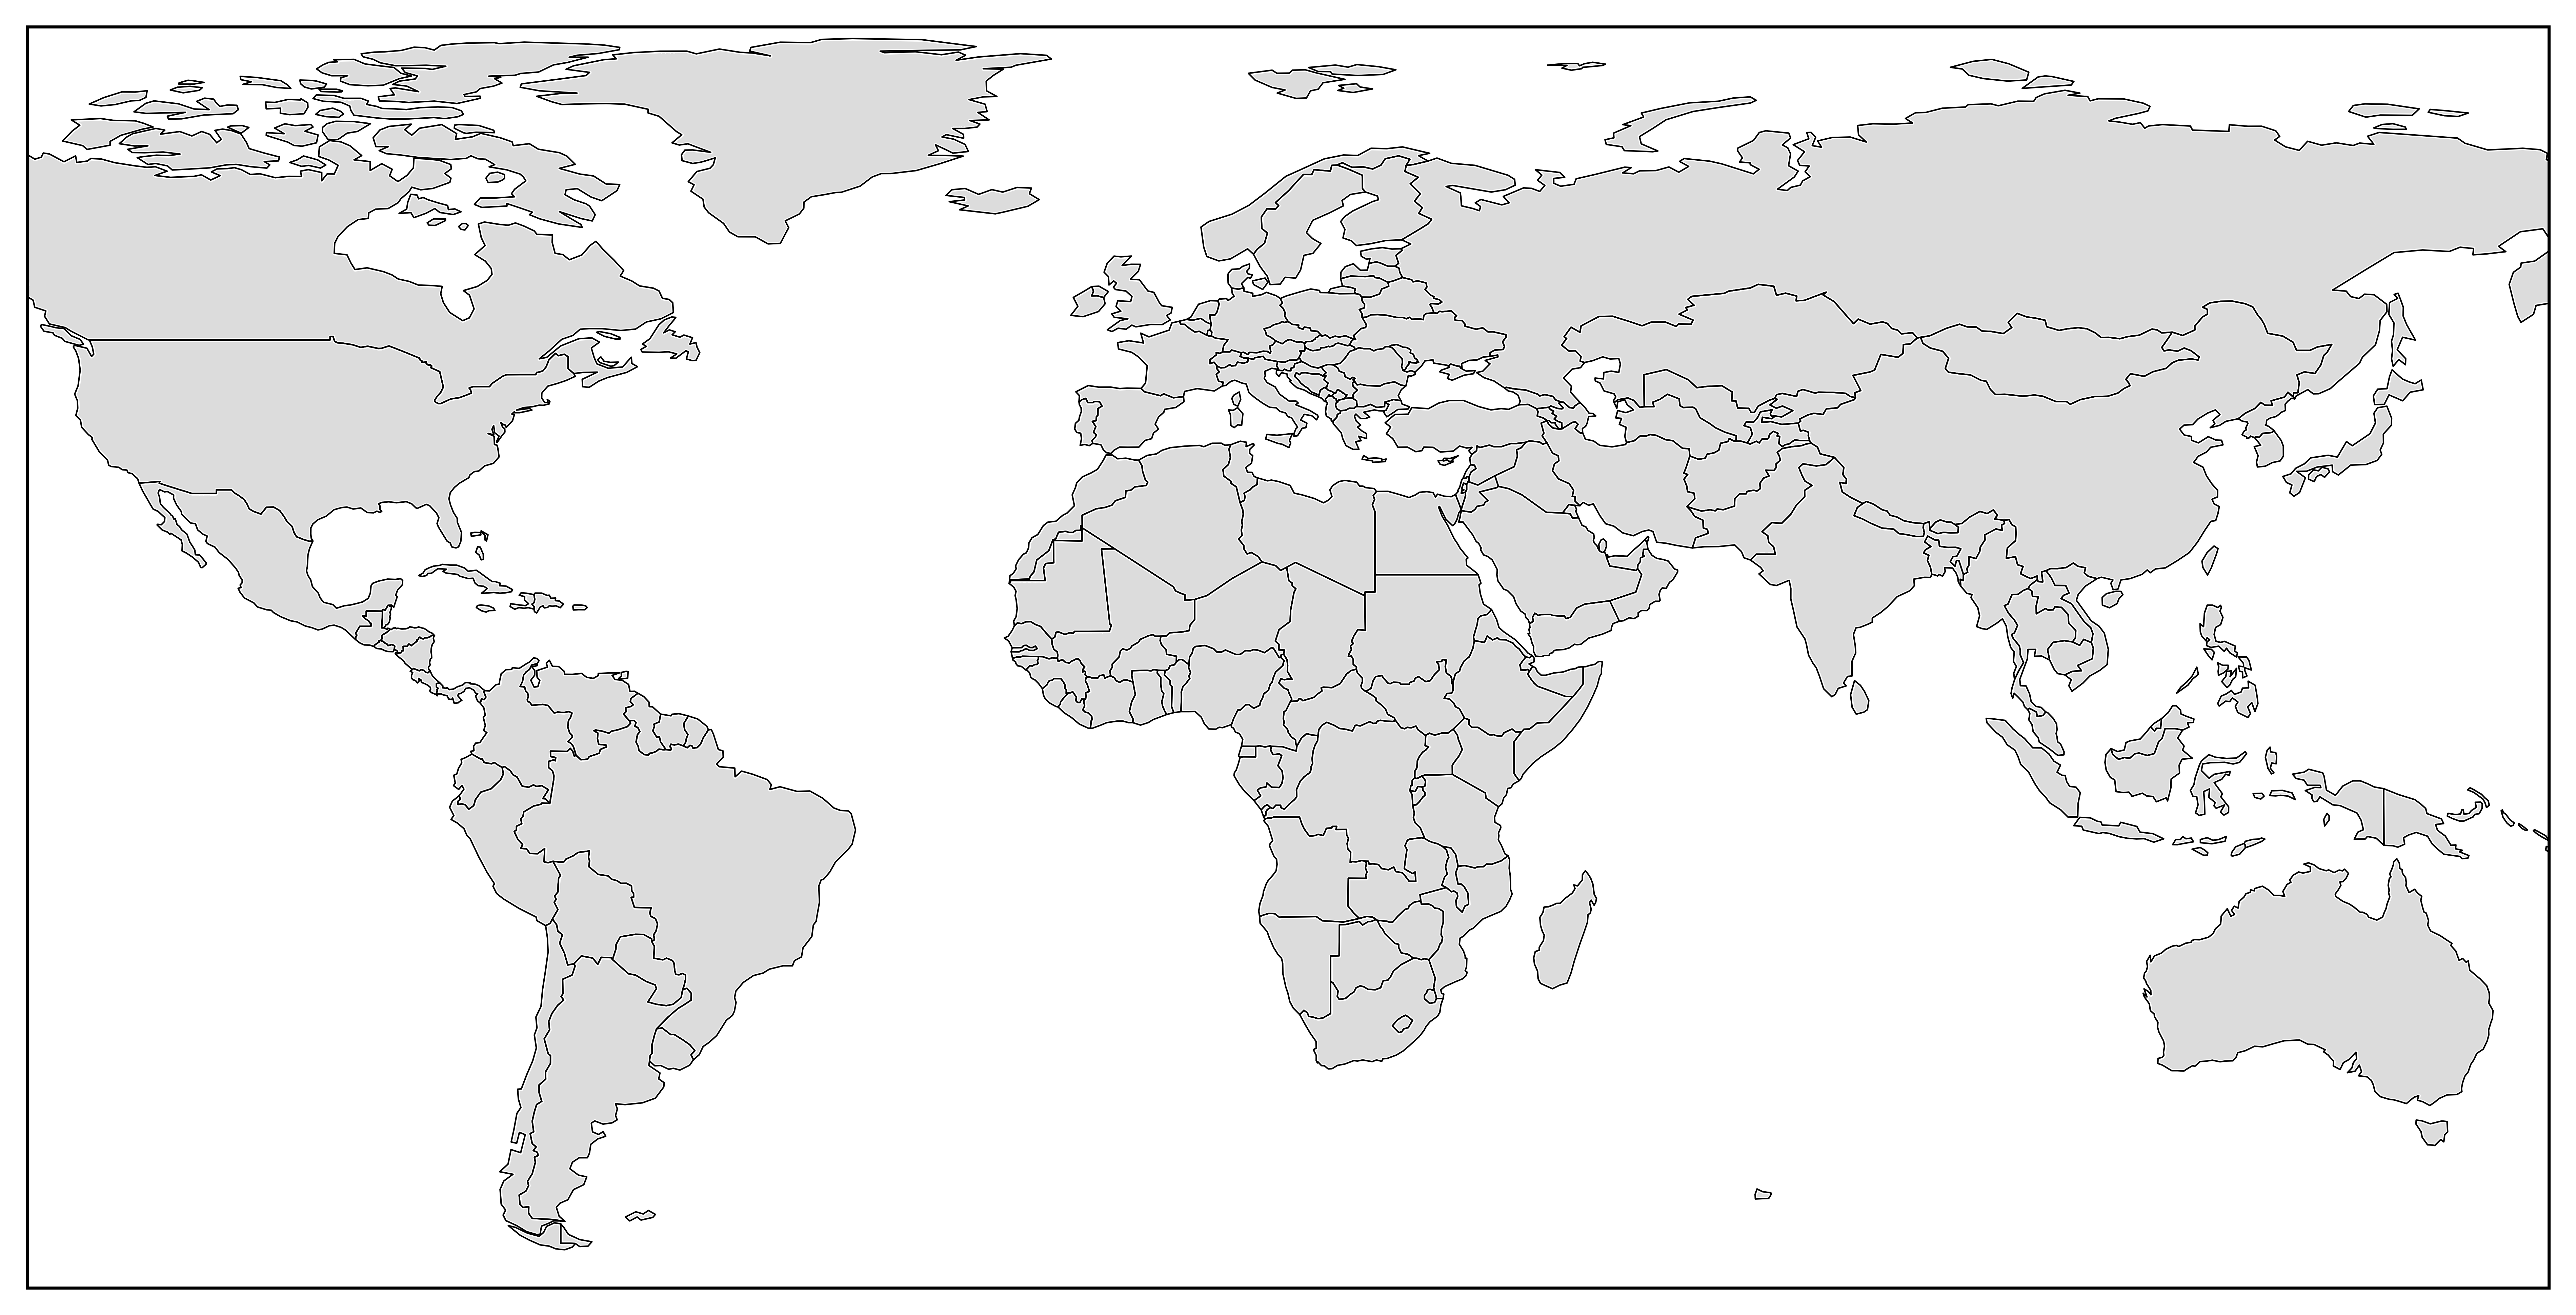

In [6]:
# ───────────────────── 6. FIGURA Y MAPA BASE ───────────────────
# Ajusta el tamaño de la figura para un mapamundi
fig = plt.figure(figsize=(12, 8), dpi=800)
ax  = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Extent mundial sin gran parte de Antártida
ax.set_extent([-130, 160, -60, 85], crs=ccrs.PlateCarree())

# Asegúrate de que la columna de nombre de país sea correcta
country_name_column = "SOVEREIGNT"

# Relleno uniforme + borde doble (halo blanco + línea negra) para los países
for country, geom in zip(gdf[country_name_column], gdf.geometry):
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      facecolor="gainsboro",     # Color de fondo para los países
                      edgecolor="white",         # Borde blanco grueso
                      linewidth=1.0, zorder=0)    # Ajuste del ancho de línea
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      facecolor="none",          # Sin relleno para el borde negro
                      edgecolor="black",         # Borde negro fino
                      linewidth=0.4, zorder=1)     # Ajuste del ancho de línea

In [7]:
# ───────────────────── 7. ARCOS Y FLECHAS ──────────────────────
# Asegúrate de que la normalización logarítmica esté definida aquí para el GROSOR y ALPHA
min_count = df_count['count'].min()
max_count = df_count['count'].max()
norm_log = colors.LogNorm(vmin=min_count, vmax=max_count)

# Ordena df_count por 'count' en orden descendente
df_count_sorted = df_count.sort_values(by='count', ascending=False)

# Define un zorder máximo para las flechas
max_arrow_zorder = 100

def bezier(x_start, y_start, x_end, y_end, rad=0.2, n_points=100):
    """
    Genera puntos de una curva de Bézier cuadrática entre dos puntos,
    con una curvatura especificada por `rad` y una cantidad de puntos `n_points`.
    NOTA: Esta función no gestiona con elegancia el cruce de antimeridianos.
    """
    # Punto de control para la curva (curvatura)
    ctrl_x = (x_start + x_end) / 2 - rad * (y_end - y_start)
    ctrl_y = (y_start + y_end) / 2 + rad * (x_end - x_start)

    t = np.linspace(0, 1, n_points)
    x_vals = (1 - t)**2 * x_start + 2 * (1 - t) * t * ctrl_x + t**2 * x_end
    y_vals = (1 - t)**2 * y_start + 2 * (1 - t) * t * ctrl_y + t**2 * y_end

    return x_vals, y_vals

for _, row in df_count_sorted.iterrows():
    parent = row["ParentCountry"]
    child = row["ChildCountry"]
    count = row["count"]
    variant = row["Variant"]

    # Agrega una verificación en caso de que un país esté en df_count pero no en coords
    if parent not in coords or child not in coords:
        continue

    x_start, y_start = coords[parent]
    x_end, y_end = coords[child]

    # --- Selecciona el color basado en la variante ---
    color = variant_colors.get(variant, 'gray')

    rad = random.uniform(-0.5, 0.5)

    # Ajusta alpha y linewidth scaling basado en el CONTEO
    alpha_value = norm_log(count)
    alpha_value = max(0.3, min(0.9, alpha_value))

    # Ajusta linewidth scaling basado en range y preferencia visual
    # Usando los mismos rangos que la leyenda: 1-10, 11-50, 51-200, >200
    if count > 200:
        linewidth_value = 2.0
    elif count > 50:
        linewidth_value = 1.6
    elif count > 10:
        linewidth_value = 1.2
    else:
        linewidth_value = 0.8


    # Zorder basado en el recuento, lo que garantiza que los recuentos más altos se dibujen en la parte superior
    zorder_value = max_arrow_zorder * (count - min_count) / (max_count - min_count)
    zorder_value = max(1, zorder_value)


    # (1) Dibuja curva con función bezier:
    x_vals, y_vals = bezier(x_start, y_start, x_end, y_end, rad, n_points=100)

    ax.plot(x_vals, y_vals, color=color, linewidth=linewidth_value, alpha=alpha_value,
            transform=ccrs.PlateCarree(), zorder=zorder_value)

    # (2) Flecha en punto medio de la curva:
    mid_idx = len(x_vals) // 2

    ax.annotate("",
                xy=(x_vals[mid_idx + 1], y_vals[mid_idx + 1]), # Punto final de la flecha
                xytext=(x_vals[mid_idx], y_vals[mid_idx]),     # Punto de inicio de la flecha
                arrowprops=dict(arrowstyle="-|>", color=color, lw=linewidth_value * 0.8, mutation_scale=5), # Ajusta mutation_scale
                annotation_clip=False,
                xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                textcoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                zorder=zorder_value + 1 # Asegúrese de que la flecha esté por encima de la línea
)

In [8]:
# ───────────────────── 8. PUNTOS Y ETIQUETAS ───────────────────
# Concatena las columnas ParentCountry y ChildCountry para obtener todos los países involucrados
all_involved_countries_in_df = pd.concat([df['ParentCountry'], df['ChildCountry']])

# Cuenta cuántas veces aparece cada país en total
total_counts_raw = all_involved_countries_in_df.value_counts()

# Filtra estas cuentas para incluir solo los países que tienen coordenadas disponibles
total_counts_for_countries_with_coords = total_counts_raw[total_counts_raw.index.isin(coords.keys())].copy()
total_counts_for_countries_with_coords.name = 'TotalCount'

# Define involved_countries_with_coords from the index of the filtered counts
involved_countries_with_coords = total_counts_for_countries_with_coords.index.tolist() # Add this line

print(f"\nCalculado total_counts_for_countries_with_coords (Pandas Series) para {len(total_counts_for_countries_with_coords)} países con movimientos y coordenadas.")
print("Países y sus conteos totales (con coordenadas):")
print(total_counts_for_countries_with_coords)

FACE = (0.886, 0.290, 0.200, 0.8)  # naranja-rojo 80 %
label_zorder = max_arrow_zorder + 10  # Un valor mayor que el zorder máximo de las flechas

# Lista para almacenar los objetos de texto que se pasarán a adjust_text
texts = []

# Define el umbral (mínimo 1 movimiento para etiquetar)
label_threshold = 1

# Itera sobre los países con movimientos y coordenadas
for country in involved_countries_with_coords:

    # Total de movimientos para este país
    total_movements_for_country = total_counts_for_countries_with_coords.get(country, 0)

    if country in coords:
        lon, lat = coords[country]

        max_total_count = total_counts_for_countries_with_coords.max() if not total_counts_for_countries_with_coords.empty else 1
        size_lut_total = ((total_counts_for_countries_with_coords / max_total_count) ** 0.5) * 2000
        size_px = size_lut_total.get(country, 80)

        # Dibuja el círculo
        radius = size_px / 20000
        circ = Circle((lon, lat), radius, facecolor=FACE,
                      edgecolor="white", lw=0.6, zorder=4,
                      transform=ccrs.PlateCarree())
        ax.add_patch(circ)

        # Añade Etiqueta si cumple el umbral
        if total_movements_for_country >= label_threshold:
            offset_lat = 0.15 if lat > -30 else -0.15
            offset_lon = 0.5
            final_lon = lon + offset_lon
            final_lat = lat + offset_lat

            # Asigna nombre visible
            if country == norm_dep('KINGDOM OF THE NETHERLANDS'):
                label_text_to_draw = 'Netherlands'
            elif country == norm_dep('UNITED STATES OF AMERICA'):
                label_text_to_draw = 'USA'
            else:
                label_text_to_draw = country.title()

            # Agrega etiqueta
            texts.append(ax.text(final_lon, final_lat, label_text_to_draw,
                                 fontsize=4,
                                 ha="left", va="center", zorder=label_zorder,
                                 bbox=dict(facecolor="white", alpha=0.7, pad=1, lw=0),
                                 transform=ccrs.PlateCarree(),
                                 fontproperties=arial_fp))

# Ajusta etiquetas automáticamente
adjust_text(texts, ax=ax,
            force_points=(0.2, 0.2),
            force_text=(0.2, 0.2),
            expand_points=(1.2, 1.2),
            expand_text=(1.2, 1.2),
            arrowprops=dict(arrowstyle='-', color='none', lw=0.3, shrinkA=5))

print(f"\nTotal de etiquetas agregadas a la lista de textos: {len(texts)}")


Calculado total_counts_for_countries_with_coords (Pandas Series) para 32 países con movimientos y coordenadas.
Países y sus conteos totales (con coordenadas):
PERU                          2784
UNITED STATES OF AMERICA      1576
CHILE                          740
ECUADOR                        147
ARGENTINA                      132
SPAIN                          127
CANADA                         110
MEXICO                          96
COSTA RICA                      89
BRAZIL                          83
COLOMBIA                        81
FRANCE                          57
ENGLAND                         50
SWEDEN                          45
GERMANY                         36
INDIA                           35
PANAMA                          26
ITALY                           24
AUSTRALIA                       21
BOLIVIA                         21
DENMARK                         18
ISRAEL                          10
EL SALVADOR                      8
SWITZERLAND                      8


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.



Total de etiquetas agregadas a la lista de textos: 32


In [9]:
# ───────────────────── 9. ESCALA 1000 km ───────────────────────
# Define la latitud donde quieres que la barra de escala sea precisa
latitude_for_scale = 30 # grados

# Define la distancia que la barra de escala representará
distance_km = 1000

# Calcula cuántos grados de longitud/latitud corresponden a la distancia en km en esa latitud.
degrees_per_km_at_lat = 1 / (111.32 * math.cos(math.radians(latitude_for_scale)))
size_in_degrees_for_distance = distance_km * degrees_per_km_at_lat

# Crea un objeto FontProperties específico para la barra de escala con el tamaño deseado
scale_font_properties = fm.FontProperties(fname='font/Arial.ttf', size=7)

# Ajusta el tamaño de la barra de escala en unidades de datos (grados)
bar = AnchoredSizeBar(ax.transData, size_in_degrees_for_distance, f'{distance_km} km', loc=4,
                      pad=0.6, color='black',
                      frameon=False, size_vertical=0.10,
                      fontproperties=scale_font_properties, # Usa el nuevo objeto FontProperties
                      )
ax.add_artist(bar)

In [10]:
# ───────────────────── 10. COMPASS ROSE ───────────

# Define la posición central del compass rose
compass_x = 154 # Ajusta la longitud hacia la derecha
compass_y = 78  # Mantiene la latitud alta

# Define el tamaño general del compass rose
compass_size = 5

# Longitud de las líneas cardinales
cardinal_length = compass_size * 0.6

# Zorder para el compass rose
compass_zorder = 50

# --- Dibuja las líneas cardinales (Norte, Sur, Este, Oeste) ---
# Línea Norte-Sur
ax.plot([compass_x, compass_x],
        [compass_y - cardinal_length, compass_y + cardinal_length],
        color='black', lw=1.5, transform=ccrs.PlateCarree(), zorder=compass_zorder)

# Línea Este-Oeste
ax.plot([compass_x - cardinal_length, compass_x + cardinal_length],
        [compass_y, compass_y],
        color='black', lw=1.5, transform=ccrs.PlateCarree(), zorder=compass_zorder)

# --- Agrega las etiquetas cardinales ---
# Etiqueta Norte
ax.text(compass_x, compass_y + cardinal_length + 0.1, 'N',
        fontsize=5, ha='center', va='bottom', color='black',
        transform=ccrs.PlateCarree(),
        fontproperties=arial_fp,
        bbox=dict(facecolor='white', alpha=0.6, pad=1, lw=0),
        zorder=compass_zorder + 1)

# Etiqueta Sur (ajusta posición)
ax.text(compass_x, compass_y - cardinal_length - 0.1, 'S',
        fontsize=5, ha='center', va='top', color='black',
        transform=ccrs.PlateCarree(),
        fontproperties=arial_fp,
        bbox=dict(facecolor='white', alpha=0.6, pad=1, lw=0),
        zorder=compass_zorder + 1)

# Etiqueta Este (ajusta posición)
ax.text(compass_x + cardinal_length + 0.1, compass_y, 'E',
        fontsize=5, ha='left', va='center', color='black',
        transform=ccrs.PlateCarree(),
        fontproperties=arial_fp,
        bbox=dict(facecolor='white', alpha=0.6, pad=1, lw=0),
        zorder=compass_zorder + 1)

# Etiqueta Oeste (ajusta posición)
ax.text(compass_x - cardinal_length - 0.1, compass_y, 'W',
        fontsize=5, ha='right', va='center', color='black',
        transform=ccrs.PlateCarree(),
        fontproperties=arial_fp,
        bbox=dict(facecolor='white', alpha=0.6, pad=1, lw=0),
        zorder=compass_zorder + 1)

# --- Añade punta de flecha Norte ---
north_tip = FancyArrowPatch((compass_x, compass_y + cardinal_length - 0.05),
                             (compass_x, compass_y + cardinal_length + 0.05),
                             mutation_scale=3,
                             lw=1.5, color='black', capstyle='round',
                             arrowstyle='-|>',
                             transform=ccrs.PlateCarree(),
                             zorder=compass_zorder)
ax.add_patch(north_tip)

In [11]:
# ───────────────────── 11. TÍTULO Y PIE ────────────────────────
plt.suptitle("Dispersión global de variantes virales entre países (2020-2024)",
             fontsize=13, fontweight='bold', y=0.988,
             fontproperties=arial_fp)

bbox = ax.get_position()
# caption = (
#     "Figura 2 | Arcos coloreados según la variante viral. Los círculos se escalan al número total de eventos registrados \n"
#     "como origen para cada departamento. El fondo muestra los límites administrativos proporcionados por el Worldometer."
# )
# Bbox(x0, y0, x1, y1)
# Opcional: envolver a ~90 caracteres para evitar líneas ultra-largas
# wrapped = "\n".join(textwrap.wrap(caption, 90))
# ── 3. Coordenadas del centro del mapa ─────────────────────────
# x_center = bbox.x0 + bbox.width / 2
# y_bottom = 0.01                # distancia vertical en fracción de figura
# ── 4. Dibujar texto centrado y con alineación adecuada ────────
# fig.text(
#     x_center, y_bottom,
#     caption,
#     ha="center", va="bottom",
#     fontsize=6.5,
#     wrap=True                  # Matplotlib ≥3.4 respeta saltos automáticos
# )

<Figure size 640x480 with 0 Axes>

In [12]:
# ───────────────────── 12. LEYENDA COMBINADA ────────────────────────

# Grosor representativo para la leyenda de color
representative_linewidth_for_color_legend = 1.0

# Rangos y grosores para la leyenda de grosor
min_count = df_count['count'].min() if not df_count.empty else 0
max_count = df_count['count'].max() if not df_count.empty else 1

# Define 4 rangos de grosor
linewidth_ranges_for_legend = [
    (0.8, f'{min_count} - 10'),
    (1.2, f'11 - 50'),
    (1.6, f'51 - 200'),
    (2.0, f'> 200')
]

# Ajusta rangos si el max_count es menor que el límite superior del rango
if max_count <= 200:
    linewidth_ranges_for_legend = [
        (0.8, f'{min_count} - 10'),
        (1.2, f'11 - 50'),
        (1.6, f'51 - {int(max_count)}') if max_count >= 51 else (1.6, None)
    ]
    if max_count <= 50:
        linewidth_ranges_for_legend = [
            (0.8, f'{min_count} - 10'),
            (1.2, f'11 - {int(max_count)}') if max_count >= 11 else (1.2, None)
        ]
        if max_count <= 10:
            linewidth_ranges_for_legend = [
                (0.8, f'{min_count} - {int(max_count)}') if max_count >= 1 else (0.8, None)
            ]

# Filtra rangos con etiqueta None
linewidth_ranges_for_legend = [item for item in linewidth_ranges_for_legend if item[1] is not None]


neutral_color_for_linewidth_legend = 'black'

# --- Creación de los Objetos de Leyenda ---

# Crea el objeto leyenda para el grosor
legend_handles_linewidth = []
legend_labels_linewidth = []
for lw, label in linewidth_ranges_for_legend:
    if lw is not None and label is not None:
        handle = Line2D([0], [0], color=neutral_color_for_linewidth_legend, lw=lw)
        legend_handles_linewidth.append(handle)
        legend_labels_linewidth.append(label)


# Crea el objeto leyenda para las variantes
legend_handles_variant = []
legend_labels_variant = []
for variant, color in variant_colors.items():
    handle = Line2D([0], [0], color=color, lw=representative_linewidth_for_color_legend)
    legend_handles_variant.append(handle)
    legend_labels_variant.append(variant)

# --- Añade Leyendas al Eje y Calcula Posiciones Dinámicamente en la Esquina Inferior Izquierda ---

try:
    # Crea un objeto FontProperties específico para las leyendas con el tamaño deseado
    # legend_font_properties = fm.FontProperties(fname=str(font_path), size=7)
    legend_font_properties = arial_fp.copy()
    legend_font_properties.set_size(7)
    
    # 1. Añade la leyenda de grosor primero:
    if legend_handles_linewidth:
        legend_linewidth = ax.legend(handles=legend_handles_linewidth, labels=legend_labels_linewidth,
                                  title="Number of Movements",
                                  loc='lower left',
                                  bbox_to_anchor=(0, 0), # Posicionada en la parte inferior
                                  ncol=2,
                                  frameon=True,
                                  prop=legend_font_properties, # Usa el nuevo objeto FontProperties
                                  title_fontsize=7) # Establece el tamaño de la fuente del título
    
        ax.add_artist(legend_linewidth)
    
        # Fuerza un renderizado para que Matplotlib calcule el tamaño y posición de la leyenda de grosor
        fig.canvas.draw()
    
        # Obtén la extensión (bounding box) de la leyenda de grosor en coordenadas de axes
        linewidth_legend_extent_display = legend_linewidth.get_window_extent()
        linewidth_legend_extent_axes = linewidth_legend_extent_display.transformed(ax.transAxes.inverted())
    
        # Añade un pequeño relleno vertical
        padding_y_variant = 0.01
        variant_legend_y0 = linewidth_legend_extent_axes.y1 + padding_y_variant
    
    
        # 2. Añade la leyenda de variante justo encima de la leyenda de grosor:
        legend_variant_color = ax.legend(handles=legend_handles_variant, labels=legend_labels_variant,
                                        title="Variant",
                                        loc='lower left',
                                        bbox_to_anchor=(0, variant_legend_y0), # Posicionada encima de la leyenda de grosor
                                        ncol=1,
                                        frameon=True,
                                        prop=legend_font_properties, # Usa el nuevo objeto FontProperties
                                        title_fontsize=7) # Establece el tamaño de la fuente del título
    
        ax.add_artist(legend_variant_color)
    
    
        # Fuerza otro renderizado para asegurar que
        fig.canvas.draw()
    
    else:
         print("No hay datos para mostrar la leyenda de grosor.")


except Exception as e:
    print(f"Error al posicionar leyendas dinámicamente: {e}")
    print("Intentando añadir leyendas en posiciones predefinidas (puede haber solapamiento).")

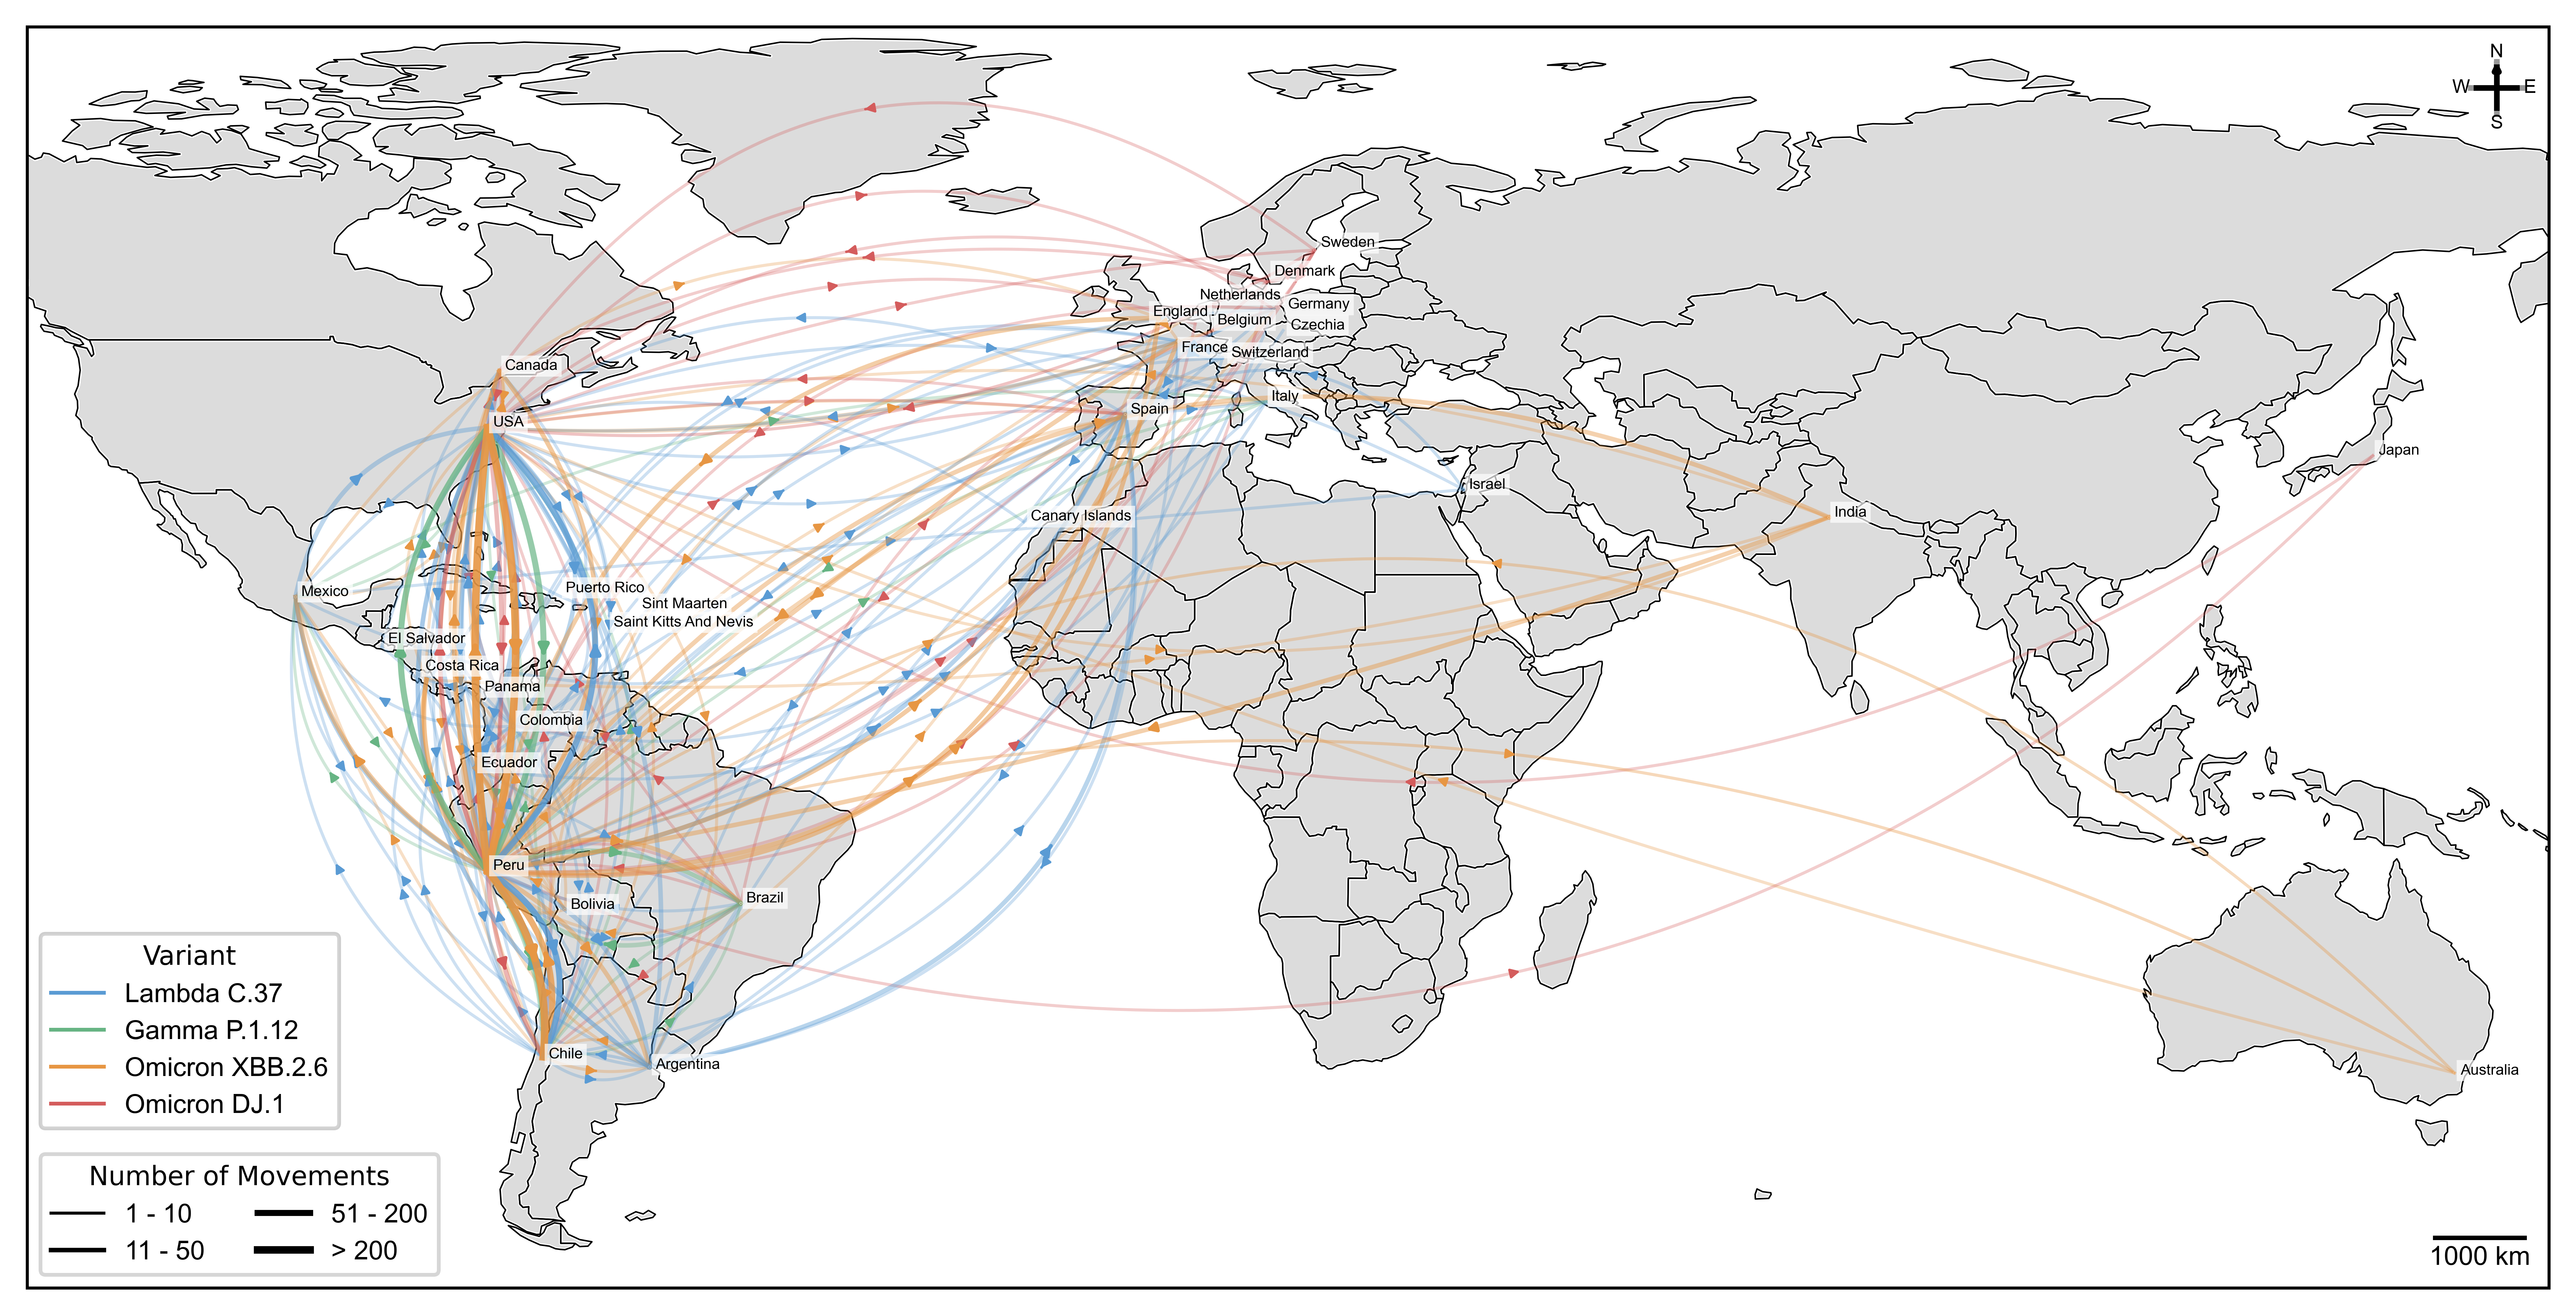

In [13]:
# ───────────────────── 13. GUARDAR Y MOSTRAR ───────────────────
fig.savefig("../output/Movimientos_Mundo.jpg", dpi=800, bbox_inches="tight")
plt.show()
fig